In [8]:
import xarray as xr
import pandas as pd
import cartopy
import matplotlib.pyplot as plt

# Create Australia wide images
Make use of `get_calibrated_grid_day.py` to generate a day of gridded data. The rest of this notebook is for visualising that information.

In [ ]:
%%capture
valid_time = "2025-01-17"

aifs = xr.load_dataset("/path/to/model_output/combined_lt/AIFS/case_study/fc_20250116_24.nc")
hres = xr.load_dataset("/path/to/model_output/combined_lt/HRES/case_study/fc_20250116_24.nc")
aifs = aifs["probability_of_lwe_thickness_of_precipitation_amount_above_threshold"]
hres = hres["probability_of_lwe_thickness_of_precipitation_amount_above_threshold"]


hres_raw = xr.load_dataset("/path/to/processed_data/HRES/20250116T1200Z-PT0024H00M-precipitation_accumulation-PT24H.nc")
hres_raw = hres_raw["lwe_thickness_of_precipitation_amount"]

aifs_raw = xr.load_dataset("/path/to/processed_data/AIFS/20250116T1200Z-PT0024H00M-precipitation_accumulation.nc")
aifs_raw = aifs_raw["lwe_thickness_of_precipitation_amount"]


study_name = "combined_lt_expected"

ground_truth_gpm = xr.load_dataset("/path/to/processed_data/GPM/test_GPM_obs.nc")
ground_truth = ground_truth_gpm.sel(time=valid_time)
ground_truth

In [10]:
def expected_value(fcst_da):
    width = (
        fcst_da["threshold"]
        .diff("threshold")
        .assign_coords({"threshold": fcst_da["threshold"].values[:-1]})
    )
    mid = fcst_da["threshold"].isel(threshold=slice(None, -1)) + width * 0.5
    diff = fcst_da.diff(dim="threshold")
    if diff.mean() < 0:
        diff = -diff
    height = diff.assign_coords({"threshold": fcst_da["threshold"].values[:-1]})
    exp_val = (height * mid).sum("threshold", skipna=False)
    exp_val.attrs["units"] = fcst_da.attrs["units"]
    return exp_val

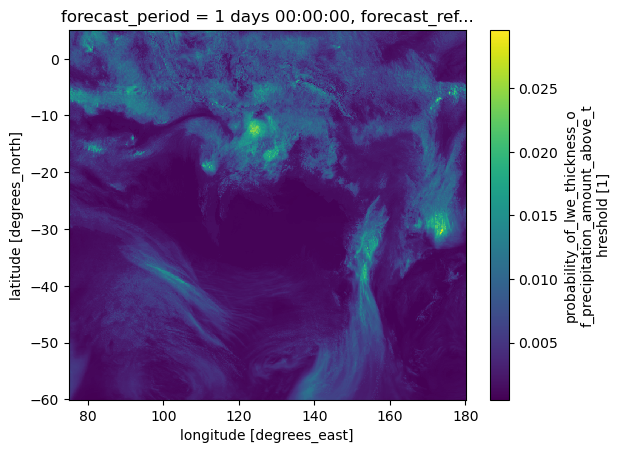

In [11]:
# calculate values
ex_HRES = expected_value(hres)
ex_AIFS = expected_value(aifs)

med_HRES = median_value(hres)
med_AIFS = median_value(aifs)

aoi = ex_HRES
aoi.plot()

# 4-panel comparing AIFS and HRES pre- and post- calibration

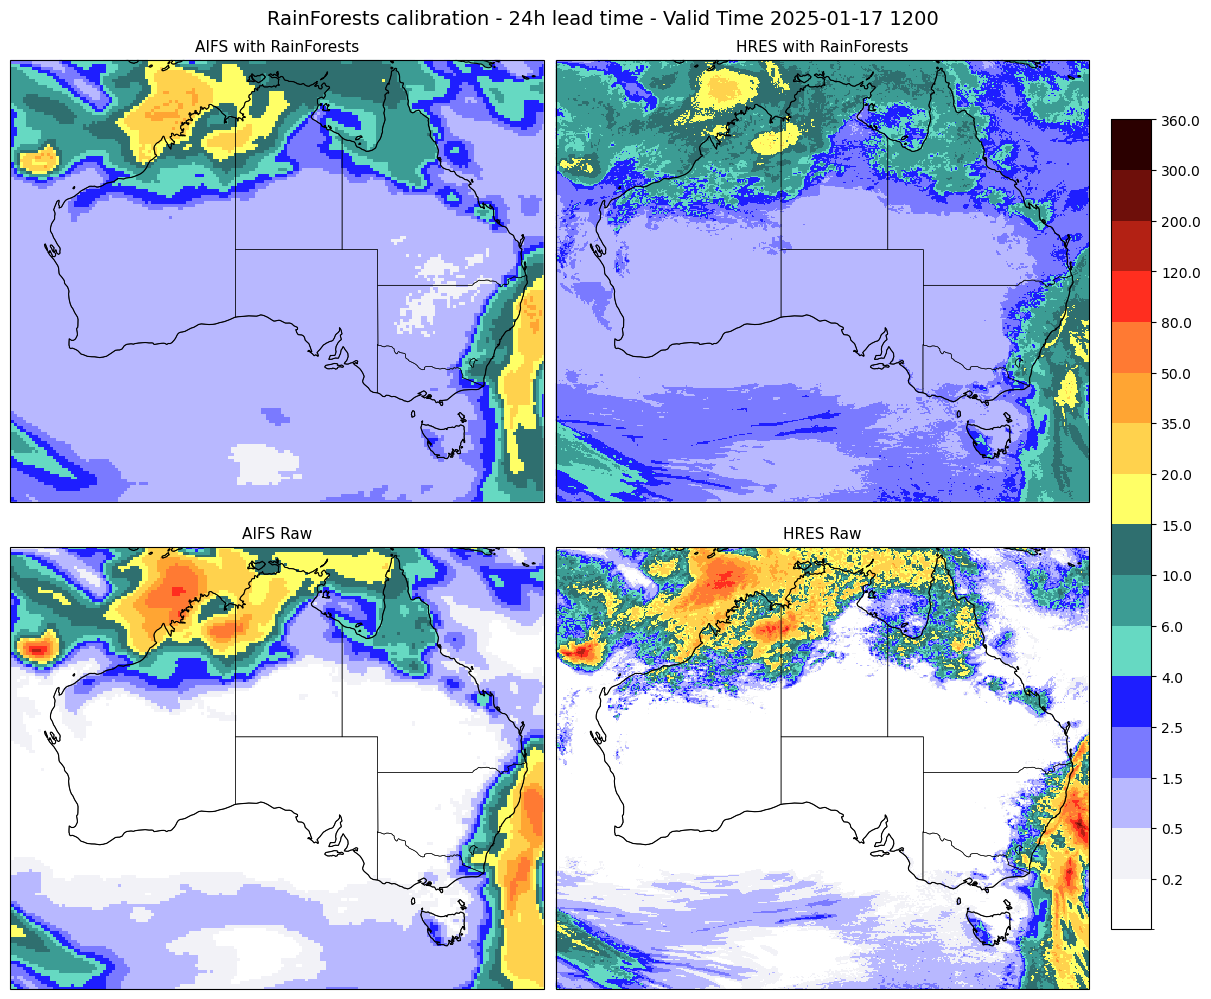

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm

import numpy as np


levels_mm = [
    0.0,
    0.2,
    0.5,
    1.5,
    2.5,
    4,
    6,
    10,
    15,
    20,
    35,
    50,
    80,
    120,
    200,
    300,
    360,
]

colors = [
    "#FFFFFF",  # off-white (very light)
    "#F2F2F7",  # off-white
    "#B8B8FF",  # sky blue
    "#7A7AFF",  # light blue
    "#1E1EFF",  # blue
    "#66D9C2",  # light cyan
    "#3C9C94",  # cyan
    "#2F6F6F",  # dark cyan
    "#FFFF66",  # yellow
    "#FFD24D",  # yellow-orange
    "#FFA533",  # orange
    "#FF7A33",  # orange-red
    "#FF2E1F",  # red
    "#B32114",  # dark red
    "#6E0F0A",  # maroon
    "#2B0000",  # dark brown
]



levels_m = [l / 1000 for l in levels_mm]

cmap = ListedColormap(colors, name="radar_rainfall")
norm = BoundaryNorm(levels_mm, cmap.N, clip=True)



vmin = min(ex_AIFS.min().item(), ex_HRES.min().item())
vmax = max(ex_AIFS.max().item(), ex_HRES.max().item())

fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(12, 10),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True,
)
# *1000 to get mm
datasets = {
    "AIFS with RainForests": ex_AIFS*1000,
    "HRES with RainForests": ex_HRES*1000,
    "AIFS Raw": aifs_raw*1000,
    "HRES Raw": hres_raw*1000
}


axes = axes.ravel()

for ax, (name, da) in zip(axes, datasets.items()):
    da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm = norm,
        add_colorbar=False,
    )

    ax.coastlines(resolution="50m", linewidth=0.8)
    ax.add_feature(cfeature.STATES, linewidth=0.4)
    ax.set_extent([110, 155, -45, -10])
    ax.set_title(name, fontsize=11)

cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axes,
    orientation="vertical",
    shrink=0.85,
    pad=0.02,
    spacing="uniform",      
    ticks=levels_mm[1:],     
)


cbar.set_label(ex_AIFS.name or "")
fig.suptitle(f"RainForests calibration - 24h lead time - Valid Time {valid_time} 1200 ", fontsize=14)
plt.savefig(f'{study_name}_{valid_time}_rainfall_case_study.png')
plt.show()

# 5-panel comparing AIFS and HRES pre- and post- calibration with observations

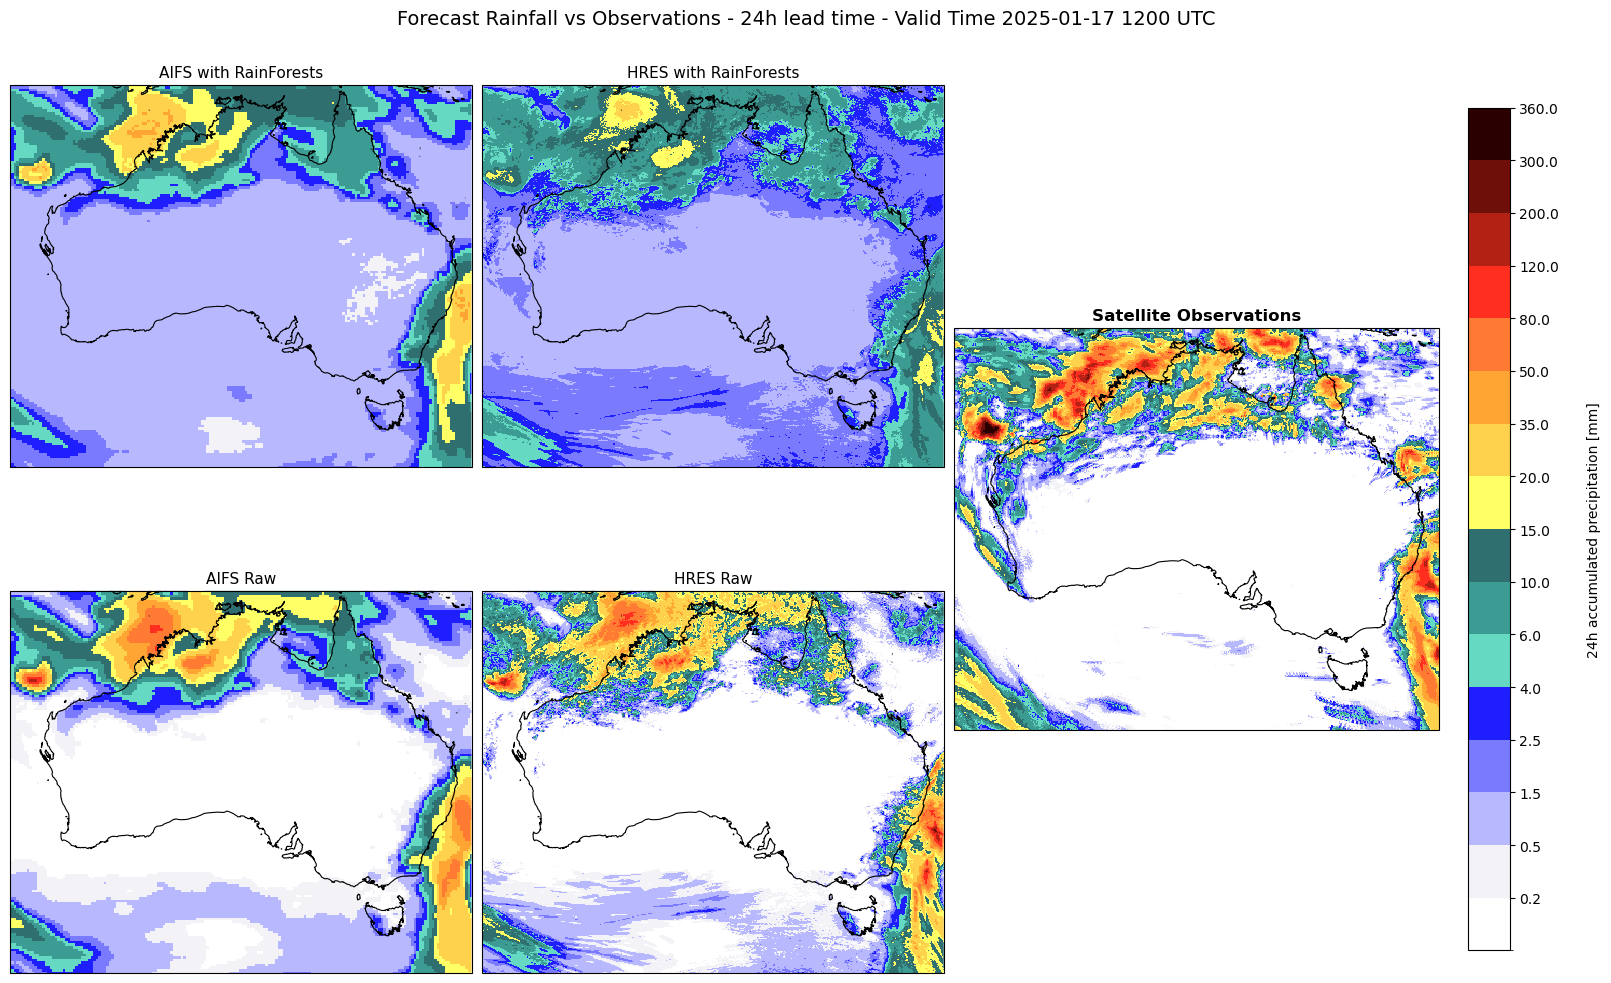

In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm

vis = ground_truth["precipitation"] 

fig = plt.figure(figsize=(16, 10), constrained_layout=True)

gs = GridSpec(
    nrows=2,
    ncols=3,
    width_ratios=[1, 1, 1.05],  # slightly wider reference
    figure=fig,
)

# Forecast panels
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())

# Reference / truth panel (spans rows)
ax_ref = fig.add_subplot(gs[:, 2], projection=ccrs.PlateCarree())

forecast_axes = [ax1, ax2, ax3, ax4]
forecast_data = {
    "AIFS with RainForests": ex_AIFS*1000,
    "HRES with RainForests": ex_HRES*1000,
    "AIFS Raw": aifs_raw*1000,
    "HRES Raw": hres_raw*1000
}

# Plot forecasts
for ax, (name, da) in zip(forecast_axes, forecast_data.items()):
    da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
    )
    ax.coastlines(resolution="10m", linewidth=0.8)
    ax.set_extent([110, 155, -45, -10])
    ax.set_title(name, fontsize=11)

# Plot ground truth
vis.plot(
    ax=ax_ref,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
)
ax_ref.coastlines(resolution="10m", linewidth=0.8)
ax_ref.set_extent([110, 155, -45, -10])
ax_ref.set_title("Satellite Observations", fontsize=12, fontweight="bold")

# Shared colourbar
cbar = fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=[*forecast_axes, ax_ref],
    orientation="vertical",
    shrink=0.85,
    pad=0.02,
    spacing="uniform",
    ticks=levels_mm[1:],
)
cbar.set_label("24h accumulated precipitation [mm]", labelpad=20)

# Overall title
fig.suptitle(
    f"Forecast Rainfall vs Observations - 24h lead time - Valid Time {valid_time} 1200 UTC",
    fontsize=14,
    y=1.02,
)
plt.savefig(f"{study_name}_{valid_time}_observations_vs_expected_forecasts.png", dpi=300)
plt.show()
